In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools
import time

from routing_v2_proj import Graph, getPaths, shortestPaths, countHops

Number of Nodes:
8
Number of links:
12.0
Average Node Degree:
[3.0]
Network Diameter:
[np.int64(3)]
Average Number of Hops per Demand:
[np.float64(1.8214285714285714)]
Minimum link length:
10.0
Maximum link length:
40.0
Average link length:
17.5
Total Number of Paths:
56
Ordered Paths:
Path: [1, 2] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[1, 2]])
Path: [2, 1] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[2, 1]])
Path: [1, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[1, 3]])
Path: [3, 1] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 1]])
Path: [2, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[2, 3]])
Path: [3, 2] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 2]])
Path: [3, 4] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 4]])
Path: [4, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[4, 3]])
Path: [3, 5] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 5]])
Path: [5, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og.

In [2]:
G = nx.Graph()

# Dictionary including city names and corresponding numbers
city_dic = {"Norden": 1, "Bremen": 2, "Hamburg": 3, "Hannover": 4, "Berlin": 5, "Leipzig": 6, "Nurnberg": 7, "Munich": 8, "Ulm": 9, "Stuttgart": 10, "Karlsruhe": 11, "Mannheim": 12, "Frankfurt": 13, "Koln": 14, "Dusseldorf": 15, "Essen": 16, "Dortmund": 17}

In [3]:
G_num = nx.Graph() # Graph with city numbers
G_name = nx.Graph() # Graph with city names

distance_factor = 2 # Given parameter

# Populate the graph with nodes
for i in city_dic:
    val = city_dic[i]
    G_num.add_node(val)
    G_name.add_node(i)

# Remove group specific node (Mannheim)
G_num.remove_node(12)
G_name.remove_node("Mannheim") 

# Original links from the website
# Tuples include: (source, destination, distance, capacity)
links = [("Munich", "Ulm",120,1), ("Munich", "Nurnberg",150,1), ("Ulm", "Stuttgart",70,1), ("Stuttgart", "Nurnberg",160,1), 
         ("Stuttgart", "Karlsruhe",60,1), ("Karlsruhe", "Mannheim",55,1), ("Mannheim", "Frankfurt",70,1), 
         ("Frankfurt", "Nurnberg",190,1), ("Nurnberg", "Leipzig",230,1), ("Frankfurt", "Leipzig",300,1), ("Frankfurt", "Hannover",265,1),
         ("Frankfurt", "Koln",155,1), ("Koln", "Dusseldorf",35,1), ("Koln", "Dortmund",75,1), ("Dusseldorf", "Essen",30,1),
         ("Essen", "Dortmund",30,1), ("Dortmund", "Hannover",185,1), ("Dortmund", "Norden",230,1), ("Norden", "Bremen",120,1),
         ("Bremen", "Hannover",100,1), ("Bremen", "Hamburg",95,1), ("Hamburg", "Berlin",255,1), ("Berlin", "Leipzig",150,1), ("Berlin", "Hannover",250,1),
         ("Leipzig", "Hannover",215,1), ("Hamburg", "Hannover",130,1)]

# Add links from Karlsruhe to Frankfurt to mitigate the absence of Mannheim
links.append(("Karlsruhe", "Frankfurt",125,1))

# Used cities (names)
names = list(G_name.nodes)

# Add edges to the graph
for i_link in links:
    src = i_link[0]
    dst = i_link[1]
    distance = i_link[2] * distance_factor
    capacity = i_link[3]

    if src in names and dst in names:
        G_name.add_edge(src, dst,length=distance, capacity=capacity)
        G_num.add_edge(city_dic[src], city_dic[dst],length=distance, capacity=capacity)
    else:
        print("City/cities not found:", i_link)

City/cities not found: ('Karlsruhe', 'Mannheim', 55, 1)
City/cities not found: ('Mannheim', 'Frankfurt', 70, 1)


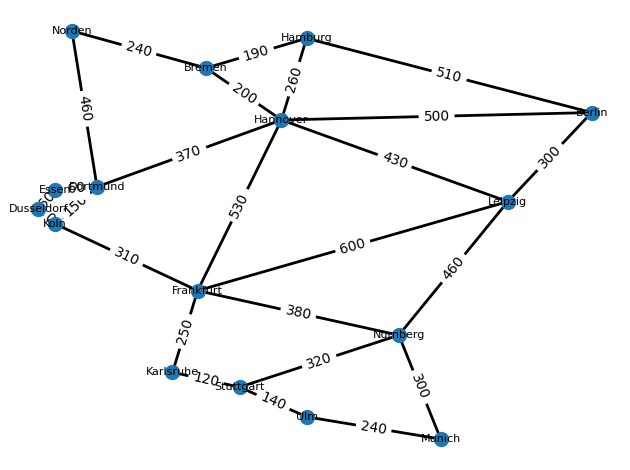

In [7]:
# DRAWING of the graph with city names

#Realistic city positions
 
POS = {
    "Norden": (7.2, 53.6), "Bremen": (8.8, 53.1), "Hamburg": (10.0, 53.5),
    "Hannover": (9.7, 52.4), "Berlin": (13.4, 52.5), "Leipzig": (12.4, 51.3),
    "Nurnberg": (11.1, 49.5), "Munich": (11.6, 48.1), "Ulm": (10.0, 48.4),
    "Stuttgart": (9.2, 48.8), "Karlsruhe": (8.4, 49.0), "Mannheim": (8.5, 49.5),
    "Frankfurt": (8.7, 50.1), "Koln": (7.0, 51.0), "Dusseldorf": (6.8, 51.2),
    "Essen": (7.0, 51.45), "Dortmund": (7.5, 51.5)
}

pos = {city: POS[city] for city in G_name.nodes()}

# nodes
nx.draw_networkx_nodes(G_name, pos, node_size=100)

# edges
nx.draw_networkx_edges(G_name, pos, edgelist=G_name.edges, width=2)

# node labels
nx.draw_networkx_labels(G_name, pos, font_size=8, font_family="sans-serif")

# edge labels
edge_lengths = nx.get_edge_attributes(G_name, "length") # Edge weights/lengths AKA the direct path distances between cities
edge_capacities = nx.get_edge_attributes(G_name, "capacity") # Capacities of the links
edge_labels = {} # Combination of lenghts and capacities 

for i, key in enumerate(edge_lengths):
    length = edge_lengths[key]
    capacity = edge_capacities[key]
    edge_labels[key] = "l: " + str(length) + ", c: " + str(capacity)

nx.draw_networkx_edge_labels(G_name, pos, edge_lengths) 

ax = plt.gca()
ax.margins(0.00115)
plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
print("#Edges:", G_name.number_of_edges(), "#Nodes:", G_name.number_of_nodes())

#Edges: 25 #Nodes: 16


Max: 6
Min: 2
Avg: 3.125
Var: 1.359375


<BarContainer object of 5 artists>

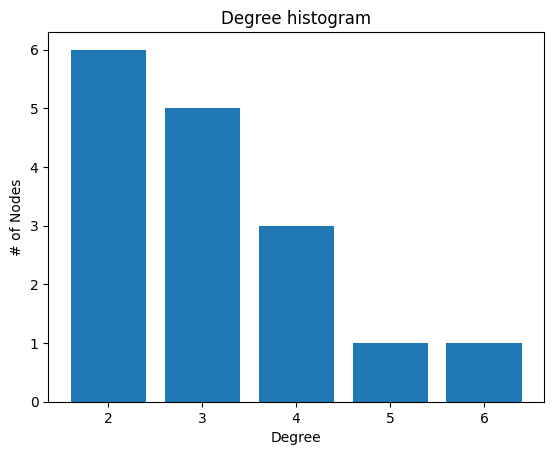

In [9]:
# DEGREE TASKS
degree_sequence = sorted((d for n, d in G_name.degree()), reverse=True)

# max, min, avg, variance
dmax = max(degree_sequence)
dmin = min(degree_sequence)
avg = np.average(degree_sequence)
var = np.var(degree_sequence)

print("Max:", dmax)
print("Min:", dmin)
print("Avg:", avg)
print("Var:", var)

# Distribution of degrees
distr = np.unique(degree_sequence, return_counts=True)

# Histogram
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")
plt.bar(*distr)

### Part 2

In [ ]:
# create adajency matrix for routing_v2_proj.py

# Node mapping (sorted node numbers -> matrix indices)
node_numbers = sorted(G_num.nodes()) 
n_nodes = len(node_numbers)

num_to_idx = {num: idx for idx, num in enumerate(node_numbers)}
idx_to_num = {idx: num for num, idx in num_to_idx.items()}
num_to_name = {v: k for k, v in city_dic.items() if v != 12}
idx_to_name = {idx: num_to_name[num] for idx, num in idx_to_num.items()}
name_to_idx = {name: idx for idx, name in idx_to_name.items()}

# Weighted adjacency matrix for distances
adj_matrix_weighted = [[0] * n_nodes for _ in range(n_nodes)]

for u, v, data in G_num.edges(data=True):
    i, j = num_to_idx[u], num_to_idx[v]
    adj_matrix_weighted[i][j] = data['length']
    adj_matrix_weighted[j][i] = data['length']

# Unweighted adjacency matrix for hops
adj_matrix_unweighted = [[0] * n_nodes for _ in range(n_nodes)]

for u, v in G_num.edges():
    i, j = num_to_idx[u], num_to_idx[v]
    adj_matrix_unweighted[i][j] = 1
    adj_matrix_unweighted[j][i] = 1

print(f"Created {n_nodes}x{n_nodes} adjacency matrix")
print(f"\nNode mapping (index -> name):")
for idx in range(n_nodes):
    print(f"  {idx+1} -> {idx_to_name[idx]}")
print(f"\nWeighted matrix (first 5 rows):")
for i in range(min(5, n_nodes)):
    print(f"  {idx_to_name[i][:6]:>6}: {adj_matrix_weighted[i][:8]}...")

Created 16x16 adjacency matrix

Node mapping (index -> name):
  1 -> Norden
  2 -> Bremen
  3 -> Hamburg
  4 -> Hannover
  5 -> Berlin
  6 -> Leipzig
  7 -> Nurnberg
  8 -> Munich
  9 -> Ulm
  10 -> Stuttgart
  11 -> Karlsruhe
  12 -> Frankfurt
  13 -> Koln
  14 -> Dusseldorf
  15 -> Essen
  16 -> Dortmund

Weighted matrix (first 5 rows):
  Norden: [0, 240, 0, 0, 0, 0, 0, 0]...
  Bremen: [240, 0, 190, 200, 0, 0, 0, 0]...
  Hambur: [0, 190, 0, 260, 510, 0, 0, 0]...
  Hannov: [0, 200, 260, 0, 500, 430, 0, 0]...
  Berlin: [0, 0, 510, 500, 0, 300, 0, 0]...


In [ ]:
# PHASE 2a: COMPUTE ALL SHORTEST PATHS

# Compute shortest paths using weighted matrix
print("\nComputing shortest paths (weighted - distances)...")
paths_weighted = shortestPaths(graph, adj_matrix_weighted)

# Compute shortest paths using unweighted matrix
print("Computing shortest paths (unweighted - hops)...")
paths_unweighted = shortestPaths(graph, adj_matrix_unweighted)

# Get hop counts
hop_matrix = countHops(paths_unweighted)

print(f"\nComputed paths for {n_nodes} nodes")
print(f"Total node pairs: {n_nodes * (n_nodes-1) // 2}")


Computing shortest paths (weighted - distances)...
Computing shortest paths (unweighted - hops)...

Computed paths for 16 nodes
Total node pairs: 120


In [30]:
# Display some example paths
print("\nExample shortest path (weighted by distance):")
print("-" * 60)

# Hamburg (idx 2) to Dusseldorf (idx 13)
hamburg_idx = name_to_idx['Hamburg']
dusseldorf_idx = name_to_idx['Dusseldorf']

path_info = paths_weighted[hamburg_idx][dusseldorf_idx]
path_nodes = path_info['path'][0]  # First path if multiple
path_names = [idx_to_name[p-1] for p in path_nodes]  # Convert to names (p is 1-indexed)

print(f"\nHamburg -> Dusseldorf:")
print(f"  Distance: {path_info['distance']} km")
print(f"  Hops: {hop_matrix[hamburg_idx][dusseldorf_idx]}")
print(f"  Path (indices): {path_nodes}")
print(f"  Path (names): {' -> '.join(path_names)}")

# # Show a few more examples
# examples = [('Berlin', 'Munich'), ('Norden', 'Stuttgart'), ('Frankfurt', 'Hamburg')]
# for src_name, dst_name in examples:
#     src_idx = name_to_idx[src_name]
#     dst_idx = name_to_idx[dst_name]
#     p = paths_weighted[src_idx][dst_idx]
#     path_names = [idx_to_name[x-1] for x in p['path'][0]]
#     print(f"\n{src_name} -> {dst_name}:")
#     print(f"  Distance: {p['distance']} km, Hops: {hop_matrix[src_idx][dst_idx]}")
#     print(f"  Path: {' -> '.join(path_names)}")


Example shortest path (weighted by distance):
------------------------------------------------------------

Hamburg -> Dusseldorf:
  Distance: 750 km
  Hops: 4
  Path (indices): [3, 4, 16, 15, 14]
  Path (names): Hamburg -> Hannover -> Dortmund -> Essen -> Dusseldorf


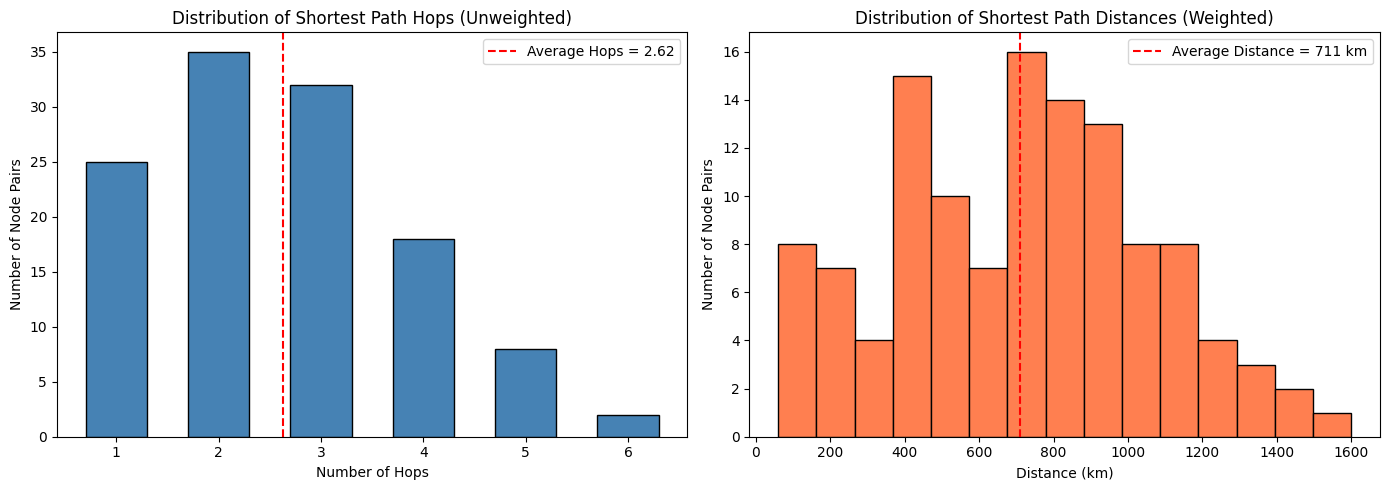


Hop distribution:
  1 hops: 25 pairs (20.8%)
  2 hops: 35 pairs (29.2%)
  3 hops: 32 pairs (26.7%)
  4 hops: 18 pairs (15.0%)
  5 hops: 8 pairs (6.7%)
  6 hops: 2 pairs (1.7%)

Distance statistics:
  Min: 60 km
  Max: 1600 km
  Avg: 711 km


In [31]:
# PHASE 2b: HISTOGRAMS FOR HOPS AND DISTANCES

# Collect all unique distances and hops
all_distances = []
all_hops = []

for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        all_distances.append(paths_weighted[i][j]['distance'])
        all_hops.append(hop_matrix[i][j])

# Create histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hop count histogram
ax1 = axes[0]
unique_hops, hop_counts = np.unique(all_hops, return_counts=True)
ax1.bar(unique_hops, hop_counts, color='steelblue', edgecolor='black', width=0.6)
ax1.set_xlabel('Number of Hops')
ax1.set_ylabel('Number of Node Pairs')
ax1.set_title('Distribution of Shortest Path Hops (Unweighted)')
ax1.set_xticks(unique_hops)
avg_hops = np.mean(all_hops)
ax1.axvline(x=avg_hops, color='red', linestyle='--', label=f'Average Hops = {avg_hops:.2f}')
ax1.legend()

# Distance histogram
ax2 = axes[1]
ax2.hist(all_distances, bins=15, color='coral', edgecolor='black')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Number of Node Pairs')
ax2.set_title('Distribution of Shortest Path Distances (Weighted)')
avg_dist = np.mean(all_distances)
ax2.axvline(x=avg_dist, color='red', linestyle='--', label=f'Average Distance = {avg_dist:.0f} km')
ax2.legend()

plt.tight_layout()
plt.savefig('phase2b_histograms.png', dpi=150)
plt.show()

print("\nHop distribution:")
for h, c in zip(unique_hops, hop_counts):
    print(f"  {h} hops: {c} pairs ({c/len(all_hops)*100:.1f}%)")

print(f"\nDistance statistics:")
print(f"  Min: {min(all_distances):.0f} km")
print(f"  Max: {max(all_distances):.0f} km")
print(f"  Avg: {avg_dist:.0f} km")

In [22]:
# PHASE 2c: AVERAGE HOPS AND NETWORK DIAMETER

# Calculate from hop matrix
hop_matrix_np = np.array(hop_matrix)
# Exclude diagonal (self-loops)
mask = ~np.eye(n_nodes, dtype=bool)
valid_hops = hop_matrix_np[mask]

avg_hops_per_demand = np.mean(all_hops)  # Using unique pairs only
diameter = max(all_hops)

print(f"\nAverage number of hops per demand <h>: {avg_hops_per_demand:.4f}")
print(f"Network diameter D: {diameter} hops")

# Estimation equations
N = n_nodes
avg_degree = avg  # From Phase 1
est_random = np.log(N) / np.log(avg_degree)  # For random graphs
est_mesh = np.sqrt(N) / 2  # For mesh-like networks

print(f"\nComparison with estimation equations:")
print(f"  Actual <h>:                        {avg_hops_per_demand:.4f}")
print(f"  Random graph: ln(N)/ln(<δ>):       {est_random:.4f}")
print(f"  Mesh network: √N/2:                {est_mesh:.4f}")

# Find which pairs have maximum hops (diameter)
print(f"\nNode pairs with maximum hops ({diameter}):")
for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        if hop_matrix[i][j] == diameter:
            print(f"  {idx_to_name[i]} <-> {idx_to_name[j]}")


Average number of hops per demand <h>: 2.6250
Network diameter D: 6 hops

Comparison with estimation equations:
  Actual <h>:                        2.6250
  Random graph: ln(N)/ln(<δ>):       2.4333
  Mesh network: √N/2:                2.0000

Node pairs with maximum hops (6):
  Norden <-> Ulm
  Ulm <-> Essen


In [ ]:
# PHASE 2d: CONNECTIVITY ANALYSIS

node_conn = nx.node_connectivity(G_name)
edge_conn = nx.edge_connectivity(G_name)

print(f"\nConnectivity metrics:")
print(f"  Node connectivity κ(G):   {node_conn}")
print(f"  Edge connectivity λ(G):   {edge_conn}")
print(f"  Minimum degree δ_min:     {dmin}")

print(f"\nWhitney's inequality: κ(G) ≤ λ(G) ≤ δ_min")
print(f"{node_conn} ≤ {edge_conn} ≤ {dmin}")


print(f"\nInterpretation:")
print(f"  - Network stays connected after removing up to {node_conn-1} nodes")
print(f"  - Network stays connected after removing up to {edge_conn-1} edges")


Connectivity metrics:
  Node connectivity κ(G):   2
  Edge connectivity λ(G):   2
  Minimum degree δ_min:     2

Whitney's inequality: κ(G) ≤ λ(G) ≤ δ_min
  2 ≤ 2 ≤ 2  ✓

Algebraic connectivity a(G): 0.3393
  (Second smallest eigenvalue of Laplacian matrix)

Interpretation:
  - Network stays connected after removing up to 1 nodes
  - Network stays connected after removing up to 1 edges


In [ ]:
# PHASE 2e: MINIMUM X-Y CUT SETS (Hamburg - Dusseldorf)

min_node_cut = nx.minimum_node_cut(G_name, 'Hamburg', 'Dusseldorf')
min_edge_cut = nx.minimum_edge_cut(G_name, 'Hamburg', 'Dusseldorf')

print(f"\nMinimum node cut set:")
print(f"  Nodes to remove: {min_node_cut}")
print(f"  Size: {len(min_node_cut)} nodes")

print(f"\nMinimum edge cut set:")
print(f"  Edges to remove: {min_edge_cut}")
print(f"  Size: {len(min_edge_cut)} edges")

print(f"\nBy Menger's theorem:")
print(f"  Max node-disjoint paths between Hamburg and Dusseldorf = {len(min_node_cut)}")
print(f"  Max edge-disjoint paths between Hamburg and Dusseldorf = {len(min_edge_cut)}")

PHASE 2e: MINIMUM CUT SETS (Hamburg - Dusseldorf)

Minimum node cut set:
  Nodes to remove: {'Koln', 'Essen'}
  Size: 2 nodes

Minimum edge cut set:
  Edges to remove: {('Essen', 'Dusseldorf'), ('Koln', 'Dusseldorf')}
  Size: 2 edges

By Menger's theorem:
  Max node-disjoint paths between Hamburg and Dusseldorf = 2
  Max edge-disjoint paths between Hamburg and Dusseldorf = 2
